In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim

import os
import pickle
import gym
import gym_ur5
import random
import numpy as np
from collections import deque

In [19]:
def mini_batch_train(env, agent, max_episodes, max_steps, batch_size):
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            if len(agent.replay_buffer) > batch_size:
                agent.update(batch_size)   

            if done or step == max_steps-1:
                episode_rewards.append(episode_reward)
                print("Episode " + str(episode) + ": " + str(episode_reward))
                break

            state = next_state
            
    return episode_rewards

In [3]:
class BasicBuffer:

    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

            return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

    def __len__(self):
        return len(self.buffer)

In [4]:
class Critic(nn.Module):

    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(self.obs_dim, 1024)
        self.linear2 = nn.Linear(1024 + self.action_dim, 512)
        self.linear3 = nn.Linear(512, 300)
        self.linear4 = nn.Linear(300, 1)

    def forward(self, x, a):
        x = F.relu(self.linear1(x))
        xa_cat = torch.cat([x,a], 1)
        xa = F.relu(self.linear2(xa_cat))
        xa = F.relu(self.linear3(xa))
        qval = self.linear4(xa)

        return qval

class Actor(nn.Module):

    def __init__(self, obs_dim, action_dim):
        super(Actor, self).__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(self.obs_dim, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, self.action_dim)

    def forward(self, obs):
        x = F.relu(self.linear1(obs))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [5]:
class TD3Agent:

    def __init__(self, env, gamma, tau, buffer_maxlen, delay_step, noise_std, noise_bound, critic_lr, actor_lr):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]

        # hyperparameters    
        self.gamma = gamma
        self.tau = tau
        self.noise_std = noise_std
        self.noise_bound = noise_bound
        self.update_step = 0 
        self.delay_step = delay_step
        
        # initialize actor and critic networks
        self.critic1 = Critic(self.obs_dim, self.action_dim).to(self.device)
        self.critic2 = Critic(self.obs_dim, self.action_dim).to(self.device)
        self.critic1_target = Critic(self.obs_dim, self.action_dim).to(self.device)
        self.critic2_target = Critic(self.obs_dim, self.action_dim).to(self.device)
        
        self.actor = Actor(self.obs_dim, self.action_dim).to(self.device)
        self.actor_target = Actor(self.obs_dim, self.action_dim).to(self.device)
    
        # Copy critic target parameters
        for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
            target_param.data.copy_(param.data)

        # initialize optimizers        
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=critic_lr)
        self.critic2_optimizer = optim.Adam(self.critic1.parameters(), lr=critic_lr) 
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        self.replay_buffer = BasicBuffer(buffer_maxlen)        

    def get_action(self, obs):
        state = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
        action = self.actor.forward(state)
        action = action.squeeze(0).cpu().detach().numpy()

        return action
    
    def update(self, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, masks = self.replay_buffer.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        masks = torch.FloatTensor(masks).to(self.device)
        
        action_space_noise = self.generate_action_space_noise(action_batch)
        next_actions = self.actor.forward(state_batch) + action_space_noise
        next_Q1 = self.critic1_target.forward(next_state_batch, next_actions)
        next_Q2 = self.critic2_target.forward(next_state_batch, next_actions)
        expected_Q = reward_batch + self.gamma * torch.min(next_Q1, next_Q2)

        # critic loss
        curr_Q1 = self.critic1.forward(state_batch, action_batch)
        curr_Q2 = self.critic2.forward(state_batch, action_batch)
        critic1_loss = F.mse_loss(curr_Q1, expected_Q.detach())
        critic2_loss = F.mse_loss(curr_Q2, expected_Q.detach())
        
        # update critics
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # delyaed update for actor & target networks  
        if(self.update_step % self.delay_step == 0):
            # actor
            self.actor_optimizer.zero_grad()
            policy_gradient = -self.critic1(state_batch, self.actor(state_batch)).mean()
            policy_gradient.backward()
            self.actor_optimizer.step()

            # target networks
            self.update_targets()

        self.update_step += 1

    def generate_action_space_noise(self, action_batch):
        noise = torch.normal(torch.zeros(action_batch.size()), self.noise_std).clamp(-self.noise_bound, self.noise_bound).to(self.device)
        return noise

    def update_targets(self):
        for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [20]:
env = gym.make('ur5-v0')

max_episodes = 10
max_steps = 500
batch_size = 32

gamma = 0.99
tau = 1e-2
noise_std = 0.2
bound = 0.5
delay_step = 2
buffer_maxlen = 100000
critic_lr = 1e-3
actor_lr = 1e-3

model_config = {
    'max_episodes':max_episodes,
    'max_steps':max_steps,
    'batch_size':batch_size,
    'gamma':gamma,
    'tau':tau,
    'critic_lr':critic_lr,
    'actor_lr':actor_lr
}

agent = TD3Agent(env, gamma, tau, buffer_maxlen, delay_step, noise_std, bound, critic_lr, actor_lr)
episode_rewards = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
plt.plot(-np.array(episode_rewards))
plt.title('average distance')

In [15]:
def play(env, agent, max_episodes, max_steps, batch_size):
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            env.render()
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            # agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            # if len(agent.replay_buffer) > batch_size:
            #     agent.update(batch_size)   

            if done or step == max_steps-1:
                episode_rewards.append(episode_reward)
                print("Episode " + str(episode) + ": " + str(episode_reward))
                break

            state = next_state

    return episode_rewards

In [16]:
inferece_rewards = play(env, agent, 10, max_steps, batch_size)

Episode 0: -17.233870914403287
Episode 1: -15.478876105687634
Episode 2: -16.41101109551765
Episode 3: -16.43865764511382
Episode 4: -19.72707892291658
Episode 5: -21.20904573810529
Episode 6: -15.537923329862515
Episode 7: -13.522122327200867
Episode 8: -17.516953897361795
Episode 9: -16.723846570753953


Text(0.5, 1.0, 'inference average distance')

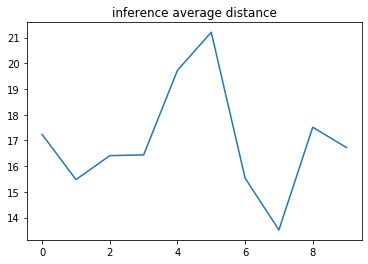

In [17]:
plt.plot(-np.array(inferece_rewards))
plt.title('inference average distance')

In [21]:
env.close()